# Download and cut data for TOF

* [National Parks (England)](https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::national-parks-england/about)


In [8]:
import requests
import geopandas as gpd
import pandas as pd
from io import BytesIO
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [12]:
# Define the URL
url = "https://services.arcgis.com/JJzESW51TqeY9uat/arcgis/rest/services/National_Parks_England/FeatureServer/0/query"

# Define query parameters
params = {
    "where": "1=1",
    "outFields": "*",
    "f": "geojson"
}

# Download the data
response = requests.get(url, params=params)
if response.status_code == 200:
    geojson_data = response.json()
else:
    raise Exception(f"Failed to download data. HTTP Status Code: {response.status_code}")

# Convert the GeoJSON to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])

# Set the CRS to EPSG:4326 (WGS84) if it is not set
gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# Filter the data where NAME = 'PEAK DISTRICT'
peak_district_gdf = gdf[gdf['NAME'] == 'PEAK DISTRICT']

# Reproject to EPSG:27700 (British National Grid)
peak_district_gdf = peak_district_gdf.to_crs("EPSG:27700")

# Save the filtered data as a shapefile
output_path = "./data/peak-district-boundary.shp"
peak_district_gdf.to_file(output_path)

/tmp/ipykernel_6308/2867544543.py:32: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  peak_district_gdf.to_file(output_path)
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape__Area' to 'Shape__Are'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Shape__Length' to 'Shape__Len'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Value 1437831812.76914978 of field Shape__Are of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


In [13]:
# Print CRS and hectares
print("Coordinate Reference System (CRS):", peak_district_gdf.crs)

# Calculate hectares and add a column (if geometry is in meters)
if peak_district_gdf.crs and peak_district_gdf.crs.is_projected:
    peak_district_gdf['area_hectares'] = peak_district_gdf.geometry.area / 10000
    print("Area in hectares:")
    print(peak_district_gdf[['NAME', 'area_hectares']])
else:
    print("CRS is not projected. Unable to calculate hectares.")

Coordinate Reference System (CRS): EPSG:27700
Area in hectares:
            NAME  area_hectares
3  PEAK DISTRICT  143781.998438


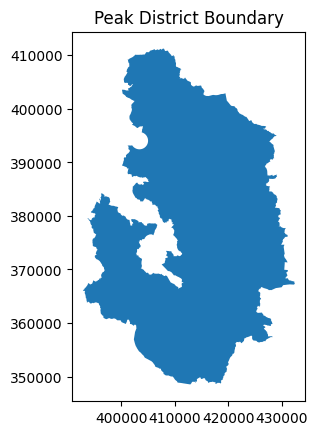

Shapefile saved to ./data/peak-district-boundary.shp


In [14]:
# Plot the Peak District boundary
peak_district_gdf.plot()
plt.title("Peak District Boundary")
plt.show()

print(f"Shapefile saved to {output_path}")

* [Priority Habitats Inventory (England)](https://naturalengland-defra.opendata.arcgis.com/datasets/39403df11c8044d998772db5b54ad86c_0/explore)

In [59]:
# Load the manually downloaded Priority Habitats data
priority_habitats_path = "./data/Priority_Habitats_Inventory_England.gpkg"
gdf_priority_habitats = gpd.read_file(priority_habitats_path)

# Print the CRS of the Priority Habitats dataset
print("Priority Habitats CRS:", gdf_priority_habitats.crs)

# Reproject to EPSG:27700 (if needed)
if gdf_priority_habitats.crs != "EPSG:27700":
    gdf_priority_habitats = gdf_priority_habitats.to_crs("EPSG:27700")

# Validate geometries in both datasets
gdf_priority_habitats = gdf_priority_habitats[gdf_priority_habitats.geometry.is_valid]
peak_district_gdf = peak_district_gdf[peak_district_gdf.geometry.is_valid]

# Clip the Priority Habitats data to the Peak District boundary
phi_peak_district_gdf = gpd.clip(gdf_priority_habitats, peak_district_gdf)

# Check if the result is empty
if phi_peak_district_gdf.empty:
    print("No overlap between Priority Habitats and Peak District boundary.")
else:
    # Save the clipped data as a shapefile
    output_path_phi_peak_district = "./data/phi-peak-district.shp"
    phi_peak_district_gdf.to_file(output_path_phi_peak_district)

    # Calculate hectares for each habitat
    phi_peak_district_gdf['area_hectares'] = phi_peak_district_gdf.geometry.area / 10000

    # Calculate statistics by 'MainHabs'
    habitat_stats = phi_peak_district_gdf.groupby('MainHabs')['area_hectares'].sum().reset_index()

    # Total area of the Peak District
    total_peak_area = peak_district_gdf['area_hectares'].sum()

    # Total area of Priority Habitats in the Peak District
    total_priority_habitats_area = habitat_stats['area_hectares'].sum()

    # Calculate percentages
    habitat_stats['% of Peak District'] = (habitat_stats['area_hectares'] / total_peak_area) * 100
    habitat_stats['% of Total Priority Habitats'] = (habitat_stats['area_hectares'] / total_priority_habitats_area) * 100

    # Add total row
    total_row = pd.DataFrame({
        'MainHabs': ['Total'],
        'area_hectares': [total_priority_habitats_area],
        '% of Peak District': [total_priority_habitats_area / total_peak_area * 100],
        '% of Total Priority Habitats': [100]
    })
    habitat_stats = pd.concat([habitat_stats, total_row], ignore_index=True)

    # Save the statistics to a CSV file
    output_csv_path = './output/phi_stats_peak_district.csv'
    habitat_stats.to_csv(output_csv_path, index=False)
    print(f"Statistics saved to {output_csv_path}")

    print("Priority Habitat Statistics:")
    print(habitat_stats)

    print(f"Priority Habitats shapefile saved to {output_path_phi_peak_district}")


Priority Habitats CRS: EPSG:27700
Statistics saved to ./output/phi_stats_peak_district.csv
Priority Habitat Statistics:
                                           MainHabs  area_hectares  \
0                                       Blanket bog   25190.514444   
1                    Blanket bog,Deciduous woodland       2.789685   
2                            Calaminarian grassland       5.393655   
3              Coastal and floodplain grazing marsh     148.606831   
4                                Deciduous woodland    6395.447494   
5                                  Fragmented heath     457.207655   
6              Good quality semi improved grassland    2080.657400   
7                                    Grass moorland    4470.283908   
8                                Limestone pavement       0.329786   
9                      Lowland calcareous grassland    2218.348014   
10  Lowland calcareous grassland,Limestone pavement       1.059982   
11                       Lowland dry aci

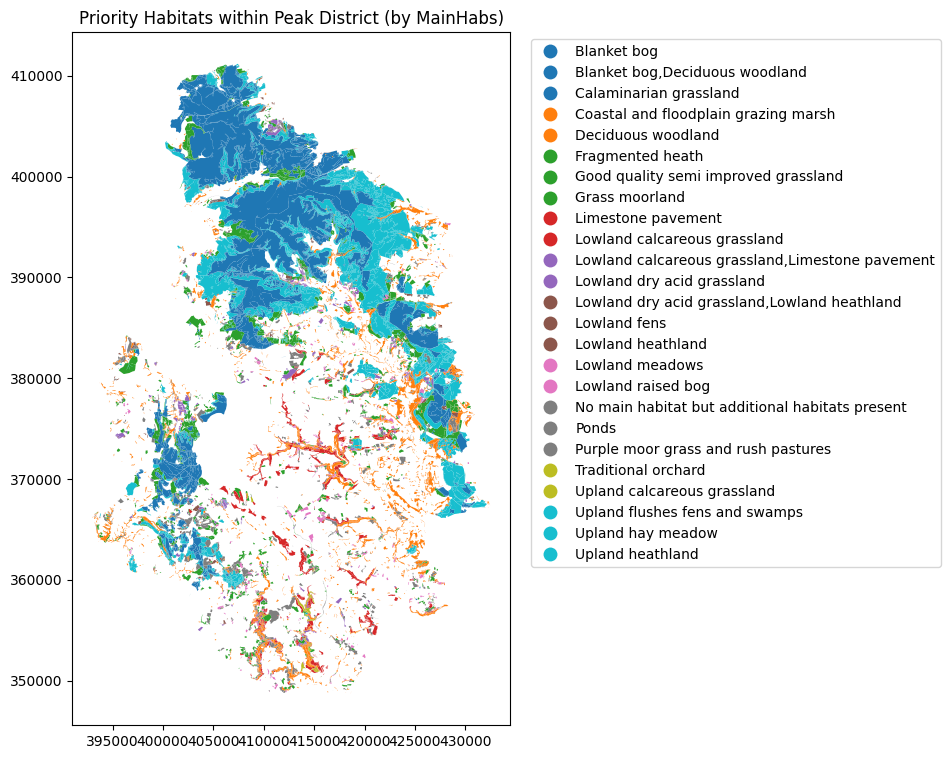

In [45]:
# Plot the clipped Priority Habitats data color-coded by 'MainHabs'
fig, ax = plt.subplots(figsize=(21, 9))
phi_peak_district_gdf.plot(column='MainHabs', legend=True, ax=ax)

# Offset the legend to the right
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((2.0, 1.0))  # Adjust (1.25, 0.5) as needed for your layout

plt.title("Priority Habitats within Peak District (by MainHabs)")
plt.show()

* [OS Built Up areas](https://osdatahub.os.uk/downloads/open)

In [52]:
# Stage 3: Load and process built-up areas
built_up_areas_path = './data/os_open_built_up_areas.gpkg'
built_up_areas_gdf = gpd.read_file(built_up_areas_path)

# Print CRS and reproject if necessary
print("Built-up Areas CRS:", built_up_areas_gdf.crs)
if built_up_areas_gdf.crs != "EPSG:27700":
    built_up_areas_gdf = built_up_areas_gdf.to_crs("EPSG:27700")

# Clip built-up areas to Peak District boundary
built_up_peak_gdf = gpd.clip(built_up_areas_gdf, peak_district_gdf)
built_up_peak_path = "./data/built-up-peak-district.shp"
built_up_peak_gdf.to_file(built_up_peak_path)
print(f"Built-up areas within Peak District saved to {built_up_peak_path}")

# Filter for polygon or multipolygon geometries only
built_up_phi_gdf = built_up_phi_gdf[built_up_phi_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Filter for polygon or multipolygon geometries only
built_up_phi_gdf = built_up_phi_gdf[built_up_phi_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Save the filtered data as a shapefile
built_up_phi_path = "./data/built-up-phi.shp"
built_up_phi_gdf.to_file(built_up_phi_path)
print(f"Built-up areas intersecting with Priority Habitats saved to {built_up_phi_path}")



# Clip built-up areas to Priority Habitats intersection
built_up_phi_gdf = gpd.clip(built_up_peak_gdf, phi_peak_district_gdf)

# Filter for polygon or multipolygon geometries only
built_up_phi_gdf = built_up_phi_gdf[built_up_phi_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Calculate intersection statistics
built_up_phi_gdf['area_hectares'] = built_up_phi_gdf.geometry.area / 10000
total_intersection_area = built_up_phi_gdf['area_hectares'].sum()

# Print total intersection area
print(f"Total intersection area of built-up areas with Priority Habitats: {total_intersection_area:.2f} hectares")


/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'os_open_built_up_areas.gpkg': 'os_open_built_up_areas' (default), 'os_open_built_up_extents', 'os_open_non_built_up_extents'. Specify layer parameter to avoid this warning.
  result = read_func(


Built-up Areas CRS: EPSG:27700
Built-up areas within Peak District saved to ./data/built-up-peak-district.shp
Built-up areas intersecting with Priority Habitats saved to ./data/built-up-phi.shp


/tmp/ipykernel_6308/2956856072.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  built_up_peak_gdf.to_file(built_up_peak_path)
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'name1_language' to 'name1_lang'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'name2_language' to 'name2_lang'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'areahectares' to 'areahectar'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'geometry_area_m' to 'geometry_a'
  ogr_write(
/tmp/ipykernel_6308/2956856072.py:24: UserWarning: Column names longer than 10 characters will be truncated

Total intersection area of built-up areas with Priority Habitats: 51.39 hectares


In [ ]:
# Define the size of a football field in hectares
football_field_area = 0.714

football_fields = intersection_area / football_field_area

# Print the result
print(f"Total intersection area is approximately {football_fields:.2f} UK football fields.")


Total intersection area is approximately 71.97 UK football fields.


In [54]:
habitat_stats.tail()

,MainHabs,area_hectares,% of Peak District,% of Total Priority Habitats
21,Upland calcareous grassland,220.794077,0.153562,0.337009
22,Upland flushes fens and swamps,881.911103,0.613367,1.346106
23,Upland hay meadow,21.277675,0.014799,0.032477
24,Upland heathland,17359.051885,12.073175,26.496004
25,Total,65515.735884,45.566021,100.000000


In [58]:
# Get the total Priority Habitats area from the habitat_stats DataFrame
phi_total_area = habitat_stats.loc[habitat_stats['MainHabs'] == 'Total', 'area_hectares'].values[0]

# Calculate the percentage of built-up areas within Priority Habitats
phi_os_percentage = (intersection_area / phi_total_area) * 100

# Print the result
print(f"Percentage of built-up areas within Priority Habitats: {phi_os_percentage:.2f}%")


Percentage of built-up areas within Priority Habitats: 0.08%
